<a href="https://colab.research.google.com/github/EmicoBinsfinder/ImperialReCoDe/blob/main/PatentClassification_Transfomer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text classification with Transformers

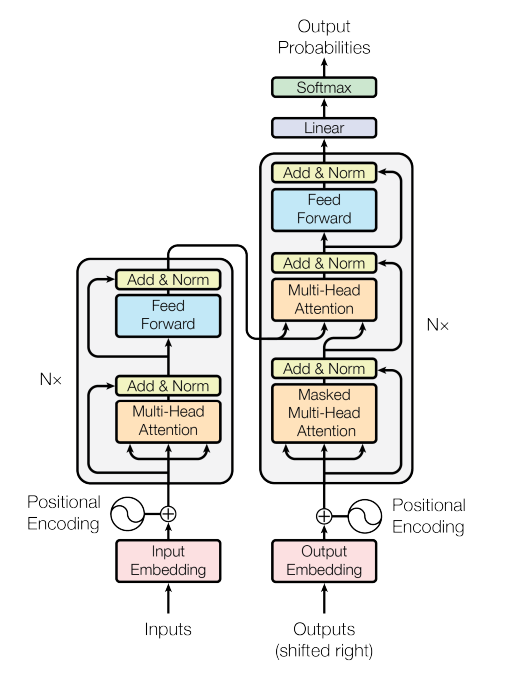

Source: [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf?ref=blog.paperspace.com)

Transformer networks are a type of neural network architecture that revolutionized natural language processing tasks by introducing a self-attention mechanism. They were introduced in the paper "Attention Is All You Need" and have since become widely used in various fields beyond language processing.

The key component of a transformer network is the self-attention mechanism, which allows the model to weigh the importance of different positions or words in the input sequence when making predictions. Unlike recurrent or convolutional architectures, transformers process the entire input sequence in parallel, making them highly parallelizable and efficient.

The main components of a transformer network are:

- Encoder: The encoder takes the input sequence and applies self-attention mechanisms to capture the relationships between all positions in the sequence. It also utilizes feed-forward neural networks to process the representations and extract higher-level features.

- Decoder: The decoder takes the encoded representations and generates predictions for the output sequence. It also employs self-attention mechanisms but adds an additional attention mechanism that allows it to focus on the encoder's output, aiding in information retrieval.

- Self-Attention: Self-attention computes attention weights for each word in the sequence based on its relationship with all other words. It captures dependencies and contextual information efficiently, allowing the model to weigh the importance of different words when making predictions.

- Multi-Head Attention: Transformer networks typically use multiple parallel self-attention heads. Each head attends to different parts of the input sequence, allowing the model to capture different types of relationships and learn diverse representations.

- Positional Encoding: Since transformers lack sequential information, positional encodings are added to each input element to provide information about its position in the sequence. These encodings enable the model to incorporate the order of words.

During training, transformer networks are optimized using variants of gradient descent and backpropagation. The objective is to minimize the difference between predicted outputs and the true targets. Notably, transformers are often pre-trained on large-scale datasets using unsupervised learning tasks, such as masked language modeling or next sentence prediction, before being fine-tuned on specific downstream tasks.

Transformers have achieved state-of-the-art performance in various natural language processing tasks, including machine translation, text summarization, sentiment analysis, and question-answering. They have also found applications beyond language processing, such as in computer vision, chemistry and recommendation systems.

In [ ]:
##### MODULE IMPORTS #####
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.utils import plot_model
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def loaddata(GreenCSV, NotGreenCSV):

  """
  Function to create a training dataset and a validation dataset (the validation
  dataset will be kept aside for when we want to evaluate model, to prevent data
  leakage)
  """

  n=90 #percentage of data that will be used during the training of the machine learning model

  GreenData_Dataframe = pd.read_csv(GreenCSV) #Read in first dataframe
  NotGreenDataFrame = pd.read_csv(NotGreenCSV) #Read in second dataframe
  MergedDataFrame = pd.concat([GreenData_Dataframe, NotGreenDataFrame[0:len(GreenData_Dataframe)]]) #Make sure equal number of entries

  MergedDataFrame = MergedDataFrame.sample(frac=1, random_state=25) #Shuffle dataframe

  TrainingDataFrame = MergedDataFrame.head(int(len(MergedDataFrame)*(n/100))) #Get n percent first rows of merged dataframe
  ValidationDataframe = MergedDataFrame.tail(int(len(MergedDataFrame)*((100-n)/100))) #Get n percent last rows of merged dataframe

  FinalDataframe = TrainingDataFrame.sample(frac=1, random_state=25) #Shuffle dataframe
  ValidationDataframe = ValidationDataframe.sample(frac=1, random_state=25) #Shuffle validation dataframe

  return FinalDataframe, ValidationDataframe

FinalDataframe, ValidationDataframe = loaddata('/content/drive/MyDrive/binary_model/GreenPatents_Dataset.csv',
                          '/content/drive/MyDrive/binary_model/NotGreenPatents_Dataset.csv')


# Checking for duplicates
total_duplicate_titles = sum(FinalDataframe["Abstract"].duplicated())

# Deleting duplicates
FinalDataframe = FinalDataframe[~FinalDataframe["Abstract"].duplicated()] #Deleting Duplicate values
FinalDataframe = FinalDataframe.dropna() #Deleting Nan values

X_train, X_test, y_train, y_test = train_test_split(FinalDataframe["Abstract"].to_numpy(),
                                                              FinalDataframe["GreenV"].to_numpy(),
                                                              test_size=0.1, # 10% of sample in test dataset
                                                              random_state=25)

#Creating dataset for validation, using a 99.99% split, as we don't need to use this portion for training
X_val, X_valnull, Y_val, Y_valnull = train_test_split(ValidationDataframe["Abstract"].to_numpy(),
                                                      ValidationDataframe["GreenV"].to_numpy(),
                                                      test_size=0.0001,
                                                      random_state=25)

# Setting up the Text Vectoriser

max_vocab_length = 140000
max_length = 50

text_vectoriser = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

text_vectoriser.adapt(X_train)
text_vectoriser.adapt(X_test)

"""
Making inputs compatible with TextVectorisation Layer
We are not going to have a text vectorisation layer in our transformer model,
so we are 'pre-vectorising'inputs using a list comprehension.
Can you think of a quicker way to do this?
"""

X_train = [text_vectoriser(str(x)) for x in X_train]
X_test = [text_vectoriser(str(x)) for x in X_test]
X_train = np.array(X_train)
X_test = np.array(X_test)

#Making validation inputs compatible with TextVectorisation Layer for inference
#X_val = [text_vectoriser(str(x)) for x in X_test]
#X_val = np.array(X_val)

Vocabulary = text_vectoriser.get_vocabulary()
max_entry_length = 200

# Implementing a Transformer Block as a Class

##What is Layer Normalisation?

Layer normalization is a technique used in deep learning models to normalize the activations of a neural network layer across the training examples.

In layer normalization, each training example's feature vector is normalized individually, treating all the values within the example's feature vector as equally important. This normalization process makes the model less sensitive to the scale of the inputs and helps the network converge faster.

The normalization process involves calculating the mean and standard deviation of the activations for each training example across the layer's dimensions. Then, these statistics are used to normalize the activations, resulting in a mean of zero and a standard deviation of one for each feature independently. Finally, learned parameters called gamma and beta are applied to scale and shift the normalized values, allowing the model to learn the optimal representation for each feature.

If you would like to learn more about layer normalisation, have a read of this [paper](https://arxiv.org/abs/1607.06450v1).

##What is Attention?

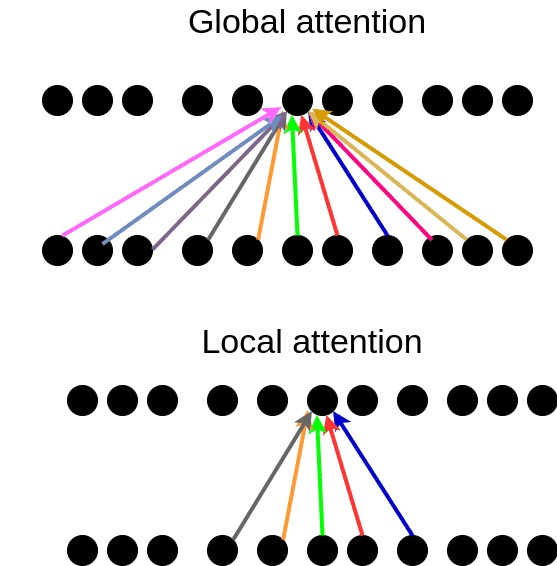

Source: [How Attention works in Deep Learning: understanding the attention mechanism in sequence models](https://theaisummer.com/attention/)

In a Transformer model, attention is a mechanism that allows the model to focus on different parts of the input sequence when processing each element. It is a key component that enables the Transformer to capture long-range dependencies and perform effectively in tasks involving sequential data, such as machine translation, text generation, and natural language processing.

The attention mechanism in a Transformer is known as "self-attention" or "scaled dot-product attention." It operates on a set of queries, keys, and values, where each element in the input sequence is associated with a query, key, and value vector. The self-attention mechanism computes a weighted sum of the values, where the weights are determined by the similarity between the query and key vectors.

Here's a high-level overview of how the self-attention mechanism works:

- Calculate Query, Key, and Value: For each input element, the Transformer applies linear transformations to generate query, key, and value vectors. These transformations project the input elements into a higher-dimensional space, allowing the model to capture more complex relationships.

- Compute Attention Scores: The self-attention mechanism calculates the attention scores by computing the dot product between the query and key vectors. The dot product represents the similarity between the query and key for a given input element.

- Apply Attention Weights: The attention scores are scaled by a factor of the square root of the dimension of the key vectors to prevent the scores from becoming too large. The scores are then passed through a softmax function, which normalizes them to obtain attention weights that sum up to 1.

- Weighted Sum of Values: The attention weights are applied to the value vectors to obtain a weighted sum. The resulting weighted sum represents the attended representation of the input sequence, with higher weights assigned to more relevant elements.

- Multi-head Attention: To capture different types of relationships and enhance the model's representation, the self-attention mechanism is typically performed multiple times in parallel. Each attention head attends to different parts of the input sequence, allowing the model to capture diverse information.

The self-attention mechanism in the Transformer model enables it to weigh the importance of different input elements dynamically, focusing on the most relevant elements for each query. This mechanism has been crucial in improving the performance of sequence-to-sequence tasks, enabling Transformers to outperform previous architectures in various natural language processing tasks.

In [ ]:
#Implementing a transformer block

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()

        #Defining the block's attention mechanism
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        #Dense layer to allow for greater capacity to learn features
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )

        #Adding layer normalisation
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        #Adding Dropout
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    #Defining the forward pass through the transformer block
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#Position Embeddings: What are they and why do transformers need them?

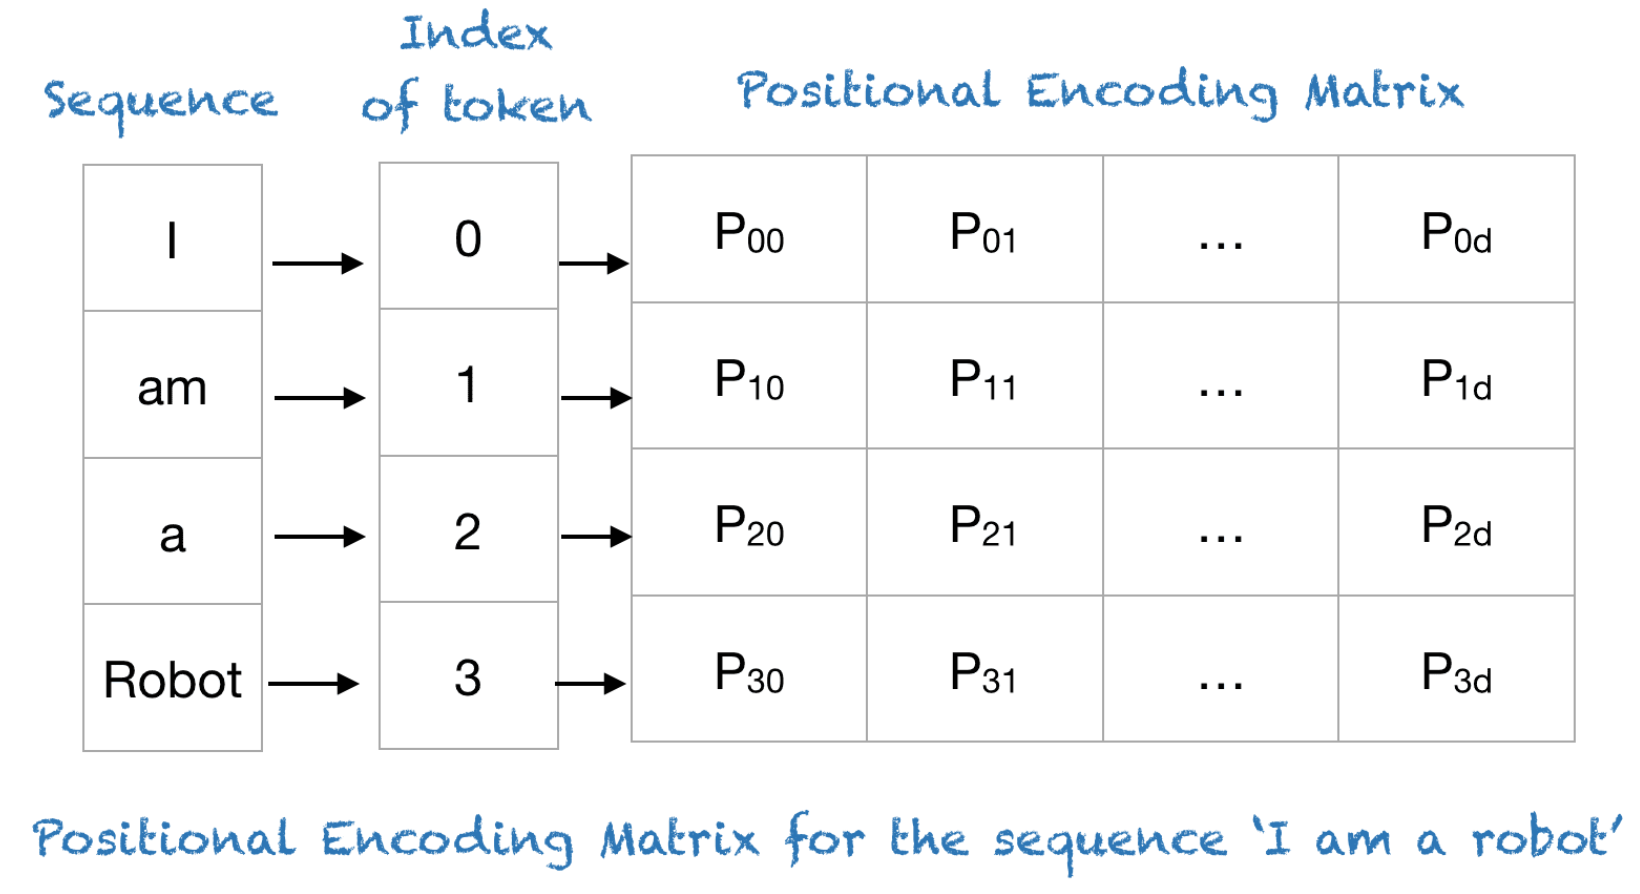

Transformers need positional embeddings because they lack the inherent notion of word order or position that is present in recurrent neural networks (RNNs) or convolutional neural networks (CNNs). Unlike RNNs, Transformers process the entire input sequence in parallel, making them highly efficient but without the sequential order information.

Positional embeddings provide a way for Transformers to encode the position or order of words in the input sequence. By incorporating positional information, the model can distinguish between words occurring at different positions and capture the sequential dependencies within the data.

Here's how positional embeddings are typically used in Transformers:

- Encoding Position Information: Positional embeddings are added to the input word embeddings or token embeddings. These embeddings are learned during the training process and contain information about the position of each word in the sequence.

- Fixed Patterns or Formulas: Positional embeddings can be generated using fixed patterns or formulas. For example, in the original Transformer model, the position embeddings were generated using sine and cosine functions with different frequencies. The choice of the pattern or formula depends on the specific application and experimentation.

- Embedding Dimension: Positional embeddings have the same dimension as the word embeddings, allowing them to be added element-wise. This combination of word embeddings and positional embeddings ensures that the model has access to both the semantic meaning of the words and their position in the sequence.

By incorporating positional embeddings, Transformers can capture the sequential relationships between words, even though they process the input sequence in parallel. This enables the model to understand the order and dependencies of words, which is essential for many natural language processing tasks, such as machine translation, language modeling, and sentiment analysis.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

##What is a Softmax Layer?

A softmax layer, also known as a softmax function or softmax activation, is a common type of activation function used at the output layer of a neural network. It is particularly popular in multiclass classification problems where the goal is to assign an input example to one of several possible classes.

The softmax function takes a vector of real-valued inputs and transforms them into a vector of values between 0 and 1, where the sum of all values is equal to 1. This transformed vector can be interpreted as a probability distribution over the classes, indicating the likelihood or confidence of the input belonging to each class.

The softmax function is defined as follows:

`softmax(z_i) = exp(z_i) / sum(exp(z_j))`

Where `z_i` represents the input to the softmax function for the i-th class, `exp()` is the exponential function, and the sum is taken over all classes.

The softmax function takes the exponential of each input value, ensuring that the resulting values are positive. Then, it normalizes the exponentiated values by dividing them by the sum of all exponentiated values. This normalization ensures that the output values lie in the range [0, 1] and sum up to 1, representing a valid probability distribution.

In a neural network, the softmax layer is typically used in the final layer for multiclass classification tasks. The output of the softmax layer is often interpreted as the predicted probabilities of each class. The class with the highest probability is then selected as the predicted class for the input example.

#Implementing and training the Transformer Network

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, max_vocab_length, embed_dim)
x = embedding_layer(inputs)

#Instantiating the transformer block from class above
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

# Creating a transformer block in the network
x = transformer_block(x)

#Downsampling for more efficient calculations in later layers
x = layers.GlobalAveragePooling1D()(x)

#Dropout layer to reduce overfitting
x = layers.Dropout(0.1)(x)

#Dense feedforward layer
x = layers.Dense(20, activation="relu")(x)

#Dropout layer to reduce overfitting
x = layers.Dropout(0.1)(x)

"""
Softmax layer needs a dimensionality of 2 as it must output a value for each
of the potential classes
"""
outputs = layers.Dense(2, activation="softmax")(x)

#Confirm model architecture by merging input and output layers
TransformerNet = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Get a summary of the model
print(TransformerNet.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddin  (None, 50, 32)           4481600   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 50, 32)           10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

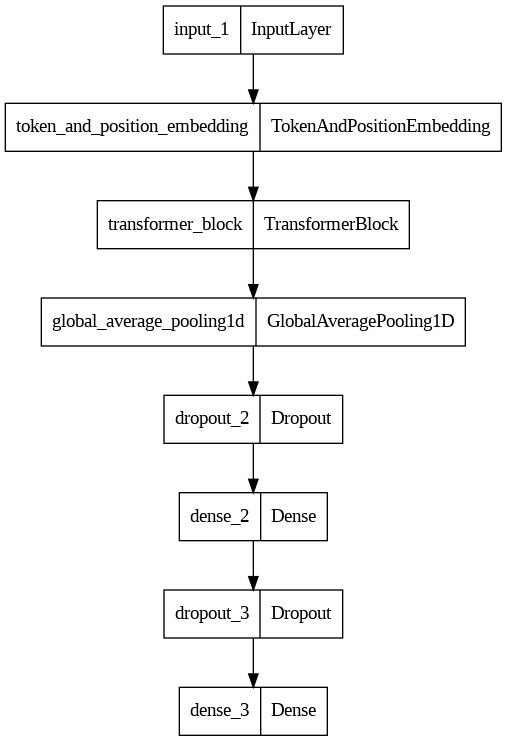

In [ ]:
#Plot model architecture
plot_model(TransformerNet)

#Set up Callbacks

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=5) # if val loss does not improve for 5 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "Checkpoints/" #path where you want you saved model to be stored
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True, #saves iteration of model with best
                                                      monitor="val_loss")

In [ ]:
#Compile and train model
TransformerNet.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

TransformerModel_history = TransformerNet.fit(X_train,
                                              y_train,
                                              batch_size=32,
                                              epochs=20,
                                              validation_data=(X_test, y_test),
                                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
3780/3780 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.8841

3780/3780 [==============================] - 136s 33ms/step - loss: 0.2791 - accuracy: 0.8841 - val_loss: 0.2283 - val_accuracy: 0.9070
Epoch 2/20
3780/3780 [==============================] - 54s 14ms/step - loss: 0.2045 - accuracy: 0.9161 - val_loss: 0.2403 - val_accuracy: 0.9050
Epoch 3/20
3780/3780 [==============================] - 52s 14ms/step - loss: 0.1750 - accuracy: 0.9260 - val_loss: 0.2495 - val_accuracy: 0.9023
Epoch 4/20
3780/3780 [==============================] - 53s 14ms/step - loss: 0.1499 - accuracy: 0.9341 - val_loss: 0.2799 - val_accuracy: 0.8975
Epoch 5/20
3780/3780 [==============================] - 59s 16ms/step - loss: 0.1300 - accuracy: 0.9419 - val_loss: 0.3399 - val_accuracy: 0.8986
Epoch 6/20
3780/3780 [==============================] - 54s 14ms/step - loss: 0.1126 - accuracy: 0.9494 - val_loss: 0.3223 - val_accuracy: 0.8939


#Evaluate Model Training and Performance

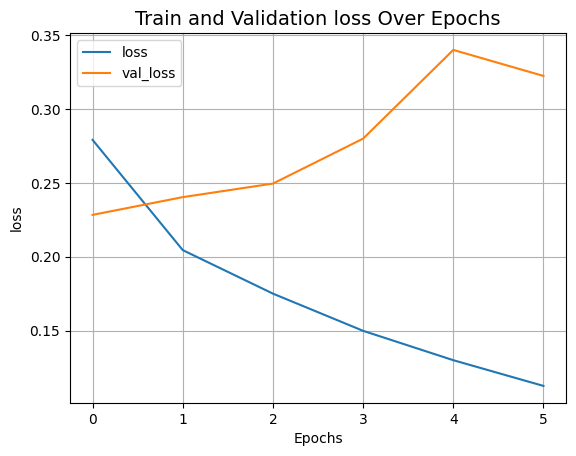

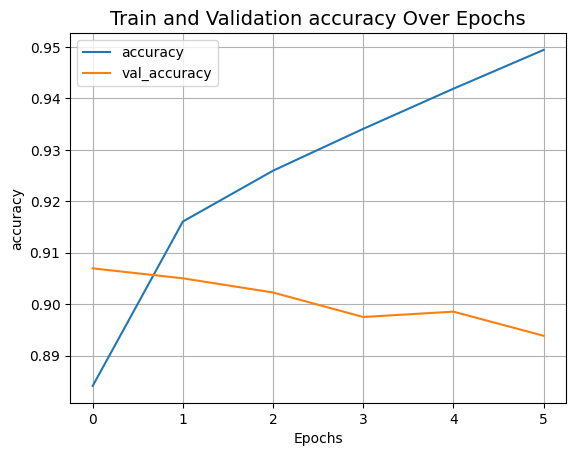

In [ ]:
def plot_result(item):
    plt.plot(TransformerModel_history.history[item], label=item)
    plt.plot(TransformerModel_history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("accuracy")

In [ ]:
def calculate_model_accuracy(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred) * 100
  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

  results = {'accuracy':accuracy,
         'precision': precision,
         'recall': recall,
         'f1': f1_score}

  return results

#Making Predictions with a Transformer

As we have used a Softmax function in our output layer, we are going to have to follow a slightly different process than we have in other notebooks to evaluate our model. The Softmax output layer gives a probability (out of 1) of the input abstract being about or not being about 'Green Plastics'.  So we have to extract the class with the highest probability from the model's predictions and treat that as our predicted class.

In [ ]:
TransformerModel_Predictions = []

#Let's loop through each entry in our validation set

for Entry in X_val:
  #Vectorising inputs before passing to model
  Vectorised_Entry = np.array(text_vectoriser(str(Entry)))

  #Reshape vector to size that transformer input layer expects
  Reshaped_Vectorised_Entry = tf.reshape(Vectorised_Entry, (1, 50, 1))

  #Perform the prediction, verbose=0 stops us getting feedback from every prediction (over 12k)
  Prediction = TransformerNet.predict(Reshaped_Vectorised_Entry, verbose=0)

  """
  See predictions for yourself, uncomment line below to see the probabilities
  of the input text belonging to one class or the other
  """
  #print(Prediction)

  Prediction= np.argmax(Prediction) #Index of highest probability in prediction array

  #Treat class with highest probability as prediction and append that to list of predictions
  #for evaluation
  TransformerModel_Predictions.append(Prediction)

#Calculate metrics based on transformer predictions
TransformerModelresult = calculate_model_accuracy(Y_val, TransformerModel_Predictions)
print(TransformerModelresult)

<class 'numpy.ndarray'>
{'accuracy': 89.31583880037488, 'precision': 0.8947631728652867, 'recall': 0.8931583880037488, 'f1': 0.8930817127570266}


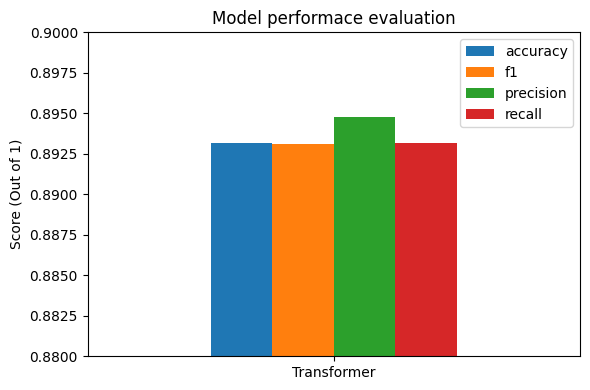

In [ ]:
#Plotting the four metrics on a bar chart
all_results = pd.DataFrame({"Transformer": TransformerModelresult})
all_results = all_results.transpose() #Formatting our dataframe so it can be plotted as a bar chart
all_results["accuracy"] = all_results["accuracy"]/100 #Normalising our accuracy score so we can plot it on the bar chart
all_results.plot(kind="bar", figsize=(6, 4))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Model performace evaluation")
plt.ylabel('Score (Out of 1)')
plt.ylim(0.88, 0.9)
plt.tight_layout()

#Extension Tasks
- Train using a GPU to see difference in speed
- Change the number of attention heads. Does this have an impact on the performance of the model?
- Could you extend this framework to perform text classification across multiple classes?
- Play around with Hyperparameters to see if performance can be improved
- Compare performance of this model with models from the other notebooks
- Try using trained models to predict on text that isn't in the dataset? Are there any situations where the model might get confused? Why might this be?